# 概要
- LongFormer
- Dropout
- AdamW
- CosineAnnealinglr
- window stride

## setup envirionment

In [ ]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
    %cd drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/main/
    !pip install  -qq sentencepiece transformers torch==1.9.1 torchvision==0.10.1 torchAudio==0.9.1 torchtext==0.10.1
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/main
     |████████████████████████████████| 1.2 MB 12.4 MB/s 
     |████████████████████████████████| 3.5 MB 42.0 MB/s 
     |████████████████████████████████| 831.4 MB 5.5 kB/s 
     |████████████████████████████████| 22.1 MB 310 kB/s 
     |████████████████████████████████| 1.9 MB 48.8 MB/s 
     |████████████████████████████████| 7.6 MB 26.5 MB/s 
     |████████████████████████████████| 6.8 MB 56.8 MB/s 
     |████████████████████████████████| 895 kB 56.2 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 


Config

In [ ]:
class Config:
    name = 'nb014'
    model_savename = 'longformer'
    
    if ON_KAGGLE:
        model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # base_dir = '/content/drive/MyDrive/petfinder'
        data_dir = '../input/feedback-prize-2021/'
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'
    else:
        # customize for my own Google Colab Environment
        # model_name = 'SpanBERT/spanbert-base-cased'
        model_name = 'allenai/longformer-base-4096' # download from Internet
        base_dir = '/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/'
        data_dir = os.path.join(base_dir, 'input/feedback-prize-2021/')
        pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{name}')
        output_dir = os.path.join(base_dir, f'output/{name}')

    is_debug = False
    load_texts = True
    n_epoch = 15 # not to exceed runtime limits on Kaggle
    n_fold = 5
    verbose_steps = 500
    random_seed = 71
    max_length =1024
    train_batch_size = 4
    valid_batch_size = 4
    lr = 5e-5
    num_labels = 15
    label_subtokens = True
    output_hidden_states = True
    hidden_dropout_prob = 0.1
    layer_norm_eps = 1e-7
    add_pooling_layer = False
    max_grad_norm = 10
    verbose_steps = 500
    if is_debug:
        debug_sample = 1000
        verbose_steps = 16
        n_epoch = 1
        n_fold = 2

constants

In [ ]:
IGNORE_INDEX = -100
NON_LABEL = -1
OUTPUT_LABELS = ['0', 'B-Lead', 'I-Lead', 'B-Position', 'I-Position', 'B-Claim', 'I-Claim', 'B-Counterclaim', 'I-Counterclaim', 
                 'B-Rebuttal', 'I-Rebuttal', 'B-Evidence', 'I-Evidence', 'B-Concluding Statement', 'I-Concluding Statement']
LABELS_TO_IDS = {v:k for k,v in enumerate(OUTPUT_LABELS)}
IDS_TO_LABELS = {k:v for k,v in enumerate(OUTPUT_LABELS)}

MIN_THRESH = {
    "I-Lead": 9,
    "I-Position": 5,
    "I-Evidence": 14,
    "I-Claim": 3,
    "I-Concluding Statement": 11,
    "I-Counterclaim": 6,
    "I-Rebuttal": 4,
}

PROB_THRESH = {
    "I-Lead": 0.7,
    "I-Position": 0.55,
    "I-Evidence": 0.65,
    "I-Claim": 0.55,
    "I-Concluding Statement": 0.7,
    "I-Counterclaim": 0.5,
    "I-Rebuttal": 0.55,
}

In [ ]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        os.makedirs(Config.model_dir, exist_ok=True)
    if not os.path.exists(Config.output_dir):
        os.makedirs(Config.output_dir, exist_ok=True)

### libraries

In [ ]:
# if not ON_KAGGLE:
#     !pip install -qq transformers

In [ ]:
# general
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import gc
from collections import defaultdict
# nlp
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
from torch import optim
from transformers import (
    LongformerConfig, 
    LongformerModel, 
    LongformerTokenizerFast,
    AutoConfig,
    AutoModel, 
    AutoTokenizer,
    logging)
logging.set_verbosity_warning()
logging.set_verbosity_error()
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

## preprocess
use corrected train.csv

https://www.kaggle.com/nbroad/corrected-train-csv-feedback-prize/notebook

In [ ]:
if ON_KAGGLE:
    df_alltrain = pd.read_csv('../input/corrected-train-csv-feedback-prize/corrected_train.csv')
else:
    df_alltrain = pd.read_csv(f'{Config.data_dir}/corrected_train.csv')

In [ ]:
def agg_essays(train_flg):
    folder = 'train' if train_flg else 'test'
    names, texts =[], []
    for f in tqdm(list(os.listdir(f'{Config.data_dir}/{folder}'))):
        names.append(f.replace('.txt', ''))
        texts.append(open(f'{Config.data_dir}/{folder}/' + f, 'r').read())
        df_texts = pd.DataFrame({'id': names, 'text': texts})

    df_texts['text_split'] = df_texts.text.str.split()
    print('Completed tokenizing texts.')
    return df_texts

In [ ]:
def ner(df_texts, df_train):
    all_entities = []
    for _,  row in tqdm(df_texts.iterrows(), total=len(df_texts)):
        total = len(row['text_split'])
        entities = ['0'] * total

        for _, row2 in df_train[df_train['id'] == row['id']].iterrows():
            discourse = row2['discourse_type']
            list_ix = [int(x) for x in row2['predictionstring'].split(' ')]
            entities[list_ix[0]] = f'B-{discourse}'
            for k in list_ix[1:]: entities[k] = f'I-{discourse}'
        all_entities.append(entities)

    df_texts['entities'] = all_entities
    print('Completed mapping discourse to each token.')
    return df_texts

In [ ]:
if not Config.load_texts:    
    def preprocess(df_train = None):
        if df_train is None:
            train_flg = False
        else:
            train_flg = True
        
        df_texts = agg_essays(train_flg)

        if train_flg:
            df_texts = ner(df_texts, df_train)
        return df_texts
    
    alltrain_texts = preprocess(df_alltrain)
    test_texts = preprocess()
    # alltrain_texts.to_pickle('../input/fb-data/alltrain_texts_correct.pkl')
    # test_texts.to_pickle('../input/fb-data/test_texts_correct.pkl')
else:
    alltrain_texts = pd.read_pickle('../input/fb-data/alltrain_texts_correct.pkl')
    test_texts = pd.read_pickle('../input/fb-data/test_texts_correct.pkl')

In [ ]:
if Config.is_debug:
    alltrain_texts = alltrain_texts.sample(Config.debug_sample).reset_index(drop=True)
print(len(alltrain_texts))

15594


set seed & split train/test

In [ ]:
def seed_everything(seed=Config.random_seed):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

seed_everything()
# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [ ]:
def split_fold(df_train):
    ids = df_train['id'].unique()
    kf = KFold(n_splits=Config.n_fold, shuffle = True, random_state=Config.random_seed)
    for i_fold, (_, valid_index) in enumerate(kf.split(ids)):
        df_train.loc[valid_index,'fold'] = i_fold
    return df_train

alltrain_texts = split_fold(alltrain_texts)
alltrain_texts.head()

,id,text,text_split,entities,fold
0,F48EF80D2ED3,There are many programs in the world around yo...,"[There, are, many, programs, in, the, world, a...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",0.0
1,F8FB4470A52F,"Dear Senator,\n\n""The Electoral College is a p...","[Dear, Senator,, ""The, Electoral, College, is,...","[0, 0, B-Lead, I-Lead, I-Lead, I-Lead, I-Lead,...",0.0
2,F176A8CF72BB,In my opinion i don't think that is fair. i th...,"[In, my, opinion, i, don't, think, that, is, f...","[B-Position, I-Position, I-Position, I-Positio...",4.0
3,EBDE7FC748A4,Unmasking the Face\n\nThe face on Mars was rea...,"[Unmasking, the, Face, The, face, on, Mars, wa...","[0, 0, 0, B-Position, I-Position, I-Position, ...",3.0
4,F6C40C564E5E,Luke think you should join the seagoing cowboy...,"[Luke, think, you, should, join, the, seagoing...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, B-Claim, I-Clai...",4.0


## dataset

In [ ]:
class FeedbackPrizeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, has_labels):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_labels = has_labels
    
    def __getitem__(self, index):
        text = self.data['text'][index]
        encoding = self.tokenizer(
            text.split(),
            is_split_into_words = True,
            padding = 'max_length',
            truncation = True,
            max_length = self.max_len
        )
        word_ids = encoding.word_ids()

        # targets
        if self.has_labels:
            word_labels = self.data.entities[index]
            prev_word_idx = None
            labels_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    labels_ids.append(IGNORE_INDEX)
                elif word_idx != prev_word_idx:
                    labels_ids.append(LABELS_TO_IDS[word_labels[word_idx]])
                else:
                    if Config.label_subtokens:
                        labels_ids.append(LABELS_TO_IDS[word_labels[word_idx]])
                    else:
                        labels_ids.append(IGNORE_INDEX)
                prev_word_idx = word_idx
            encoding['labels'] = labels_ids
        # convert to torch.tensor
        item = {k: torch.as_tensor(v) for k, v in encoding.items()}
        word_ids2 = [w if w is not None else NON_LABEL for w in word_ids]
        item['word_ids'] = torch.as_tensor(word_ids2)
        return item

    def __len__(self):
        return self.len

## model

In [ ]:
class FeedbackModel(nn.Module):
    def __init__(self):
        super(FeedbackModel, self).__init__()
        model_config = LongformerConfig.from_pretrained(Config.model_name)
        self.model_config = model_config
        self.model = LongformerModel.from_pretrained(Config.model_name, config=model_config)
        self.head = nn.Linear(model_config.hidden_size, Config.num_labels)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, input_ids, mask):
        x = self.model(input_ids, mask)
        x = x[0]
        x = self.dropout(x)
        logits = self.head(x)
        return logits

## utility function

In [ ]:
def active_logits(raw_logits, word_ids):
    word_ids = word_ids.view(-1)
    active_mask = word_ids.unsqueeze(1).expand(word_ids.shape[0], Config.num_labels)
    active_mask = active_mask != NON_LABEL
    active_logits = raw_logits.view(-1, Config.num_labels)
    active_logits = torch.masked_select(active_logits, active_mask) # return 1dTensor
    active_logits = active_logits.view(-1, Config.num_labels) 
    return active_logits

def active_labels(labels):
    active_mask = labels.view(-1) != IGNORE_INDEX
    active_labels = torch.masked_select(labels.view(-1), active_mask)
    return active_labels

def active_preds_prob(active_logits):
    active_preds = torch.argmax(active_logits, axis = 1)
    active_preds_prob, _ = torch.max(active_logits, axis = 1)
    return active_preds, active_preds_prob

## evaluating function

In [ ]:
def calc_overlap(row):
    """
    calculate the overlap between prediction and ground truth
    """
    set_pred = set(row.new_predictionstring_pred.split(' '))
    set_gt = set(row.new_predictionstring_gt.split(' '))
    # length of each end intersection
    len_pred = len(set_pred)
    len_gt = len(set_gt)
    intersection = len(set_gt.intersection(set_pred))
    overlap_1 = intersection / len_gt
    overlap_2 = intersection / len_pred
    return [overlap_1, overlap_2]

def score_feedback_comp(pred_df, gt_df):
    """
    A function that scores for the kaggle
        Student Writing Competition
        
    Uses the steps in the evaluation page here:
        https://www.kaggle.com/c/feedback-prize-2021/overview/evaluation
    """
    gt_df = gt_df[['id', 'discourse_type', 'new_predictionstring']].reset_index(drop = True).copy()
    pred_df = pred_df[['id', 'class', 'new_predictionstring']].reset_index(drop = True).copy()
    gt_df['gt_id'] = gt_df.index
    pred_df['pred_id'] = pred_df.index
    joined = pred_df.merge(
        gt_df,
        left_on = ['id', 'class'],
        right_on = ['id', 'discourse_type'],
        how = 'outer',
        suffixes = ['_pred', '_gt']
    )
    joined['new_predictionstring_gt'] =  joined['new_predictionstring_gt'].fillna(' ')
    joined['new_predictionstring_pred'] =  joined['new_predictionstring_pred'].fillna(' ')
    joined['overlaps'] = joined.apply(calc_overlap, axis = 1)
    # overlap over 0.5: true positive
    # If nultiple overlaps exists, the higher is taken.
    joined['overlap1'] = joined['overlaps'].apply(lambda x: eval(str(x))[0])
    joined['overlap2'] = joined['overlaps'].apply(lambda x: eval(str(x))[1])

    joined['potential_TP'] = (joined['overlap1'] >= 0.5) & (joined['overlap2'] >= 0.5)
    joined['max_overlap'] = joined[['overlap1', 'overlap2']].max(axis = 1)
    tp_pred_ids = joined.query('potential_TP').sort_values('max_overlap', ascending = False)\
                  .groupby(['id', 'new_predictionstring_gt']).first()['pred_id'].values
    
    fp_pred_ids = [p for p in joined['pred_id'].unique() if p not in tp_pred_ids]
    matched_gt_ids = joined.query('potential_TP')['gt_id'].unique()
    unmatched_gt_ids = [c for c in joined['gt_id'].unique() if c not in matched_gt_ids]

    TP = len(tp_pred_ids)
    FP = len(fp_pred_ids)
    FN = len(unmatched_gt_ids)
    macro_f1_score = TP / (TP + 1/2 * (FP + FN))
    return macro_f1_score

def oof_score(df_val, oof):
    f1score = []
    classes = ['Lead', 'Position','Claim', 'Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    for c in classes:
        pred_df = oof.loc[oof['class'] == c].copy()
        gt_df = df_val.loc[df_val['discourse_type'] == c].copy()
        f1 = score_feedback_comp(pred_df, gt_df)
        print(f'{c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    return f1avg

## inferencing function

In [ ]:
def inference(model, dl, criterion, valid_flg):
    final_predictions = []
    final_predictions_prob = []
    stream = tqdm(dl)
    model.eval()
    
    valid_loss = 0
    valid_accuracy = 0
    all_logits = None
    for batch_idx, batch in enumerate(stream, start = 1):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        with torch.no_grad():
            raw_logits = model(input_ids=ids, mask = mask)
        del ids, mask
        
        word_ids = batch['word_ids'].to(device, dtype = torch.long)
        if valid_flg:    
            raw_labels = batch['labels'].to(device, dtype = torch.long)
            logits = active_logits(raw_logits, word_ids)
            labels = active_labels(raw_labels)
            preds, preds_prob = active_preds_prob(logits)
            valid_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            loss = criterion(logits, labels)
            valid_loss += loss.item()
        
        if batch_idx == 1:
            all_logits = raw_logits.cpu().numpy()
        else:
            all_logits = np.append(all_logits, raw_logits.cpu().numpy(), axis=0)

    
    if valid_flg:        
        epoch_loss = valid_loss / batch_idx
        epoch_accuracy = valid_accuracy / batch_idx
    else:
        epoch_loss, epoch_accuracy = 0, 0
    return all_logits, epoch_loss, epoch_accuracy


def preds_class_prob(all_logits, dl):
    print("predict target class and its probabilty")
    final_predictions = []
    final_predictions_score = []
    stream = tqdm(dl)
    len_sample = all_logits.shape[0]

    for batch_idx, batch in enumerate(stream, start=0):
        for minibatch_idx in range(Config.valid_batch_size):
            sample_idx = int(batch_idx * Config.valid_batch_size + minibatch_idx)
            if sample_idx > len_sample - 1 : break
            word_ids = batch['word_ids'][minibatch_idx].numpy()
            predictions =[]
            predictions_prob = []
            pred_class_id = np.argmax(all_logits[sample_idx], axis=1)
            pred_score = np.max(all_logits[sample_idx], axis=1)
            pred_class_labels = [IDS_TO_LABELS[i] for i in pred_class_id]
            prev_word_idx = -1
            for idx, word_idx in enumerate(word_ids):
                if word_idx == -1:
                    pass
                elif word_idx != prev_word_idx:
                    predictions.append(pred_class_labels[idx])
                    predictions_prob.append(pred_score[idx])
                    prev_word_idx = word_idx
            final_predictions.append(predictions)
            final_predictions_score.append(predictions_prob)
    return final_predictions, final_predictions_score

In [ ]:
def get_preds_onefold(model, df, dl, criterion, valid_flg):
    logits, valid_loss, valid_acc = inference(model, dl, criterion, valid_flg)
    all_preds, all_preds_prob = preds_class_prob(logits, dl)
    df_pred = post_process_pred(df, all_preds, all_preds_prob)
    return df_pred, valid_loss, valid_acc

def get_preds_folds(df, dl, criterion, valid_flg=False):
    for i_fold in range(Config.n_fold):
        model_filename = os.path.join(Config.model_dir, f"{Config.model_savename}_{i_fold}.bin")
        print(f"{model_filename} inference")
        model = FeedbackModel()
        model = model.to(device)
        model.load_state_dict(torch.load(model_filename))
        logits, valid_loss, valid_acc = inference(model, dl, criterion, valid_flg)
        if i_fold == 0:
            avg_pred_logits = logits
        else:
            avg_pred_logits += logits
    avg_pred_logits /= Config.n_fold
    all_preds, all_preds_prob = preds_class_prob(avg_pred_logits, dl)
    df_pred = post_process_pred(df, all_preds, all_preds_prob)
    return df_pred

def post_process_pred(df, all_preds, all_preds_prob):
    final_preds = []
    for i in range(len(df)):
        idx = df.id.values[i]
        pred = all_preds[i]
        pred_prob = all_preds_prob[i]
        j = 0
        while j < len(pred):
            cls = pred[j]
            if cls == '0': j += 1
            else: cls = cls.replace('B', 'I')
            end = j + 1
            while end < len(pred) and pred[end] == cls:
                end += 1
            if cls != '0' and cls !='':
                avg_score = np.mean(pred_prob[j:end])
                if end - j > MIN_THRESH[cls] and avg_score > PROB_THRESH[cls]:
                    final_preds.append((idx, cls.replace('I-', ''), ' '.join(map(str, list(range(j, end))))))
            j = end
    df_pred = pd.DataFrame(final_preds)
    df_pred.columns = ['id', 'class', 'new_predictionstring']
    return df_pred

## training and validating function

In [ ]:
def train_fn(model, dl_train, optimizer, epoch, criterion, scheduler):
    model.train()
    train_loss = 0
    train_accuracy = 0
    stream = tqdm(dl_train)
    scaler = GradScaler()

    for batch_idx, batch in enumerate(stream, start = 1):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        raw_labels = batch['labels'].to(device, dtype = torch.long)
        word_ids = batch['word_ids'].to(device, dtype = torch.long)
        optimizer.zero_grad()
        with autocast():
            raw_logits = model(input_ids = ids, mask = mask)
        
        logits = active_logits(raw_logits, word_ids)
        labels = active_labels(raw_labels)
        preds, preds_prob = active_preds_prob(logits)
        train_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        # loss.backward()
        scaler.step(optimizer)
        scaler.update()
        # torch.nn.utils.clip_grad_norm_(
            # parameters=model.parameters(), max_norm=Config.max_grad_norm
        # )
        # optimizer.step()
        scheduler.step()
        train_loss += loss.item()

        if batch_idx % Config.verbose_steps == 0:
            loss_step = train_loss / batch_idx
            print(f'Epoch {epoch}/{Config.n_epoch} | {batch_idx:04d} steps: {loss_step}')

    epoch_loss = train_loss / batch_idx
    epoch_accuracy = train_accuracy / batch_idx
    del dl_train, raw_logits, logits, raw_labels, preds, labels
    torch.cuda.empty_cache()
    gc.collect()
    print(f'epoch {epoch} - training loss: {epoch_loss:.4f}')
    print(f'epoch {epoch} - training accuracy: {epoch_accuracy:.4f}')
    return epoch_loss

In [ ]:
def valid_fn(model, df_val, df_val_eval, dl_val, epoch, criterion):
    oof, valid_loss, valid_acc  = get_preds_onefold(model, df_val, dl_val, criterion, valid_flg=True)
    f1score =[]
    # classes = oof['class'].unique()
    classes = ['Lead', 'Position', 'Claim','Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    print(f"Validation F1 scores")

    for c in classes:
        pred_df = oof.loc[oof['class'] == c].copy()
        gt_df = df_val_eval.loc[df_val_eval['discourse_type'] == c].copy()
        f1 = score_feedback_comp(pred_df, gt_df)
        print(f' * {c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    print(f'Overall Validation avg F1: {f1avg:.4f} val_loss:{valid_loss:.4f} val_accuracy:{valid_acc:.4f}')
    return valid_loss, oof, f1avg

# Early Stopping

In [ ]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, direction='max'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.direction = direction
        if self.direction == 'max':
            self.val_loss_init = -np.Inf
        elif self.direction == 'min':
            self.val_loss_init = np.Inf

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        if self.direction == 'max':
            self.score = val_loss
        elif self.direction == 'min':
            self.score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = self.score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif self.score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = self.score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            if self.direction == 'max':
                print(f'Validation loss increased ({self.val_loss_init:.6f} --> {val_loss:.6f}).  Saving model ...')
            else:
                print(f'Validation loss decreased ({self.val_loss_init:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_init = val_loss  #その時のlossを記録する

# Training loop



================================================== Fold0 training ==================================================


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 1/15 | 0500 steps: 1.086884765625
Epoch 1/15 | 1000 steps: 0.959510009765625
Epoch 1/15 | 1500 steps: 0.88734912109375
Epoch 1/15 | 2000 steps: 0.8508994140625
Epoch 1/15 | 2500 steps: 0.82546328125
Epoch 1/15 | 3000 steps: 0.8058563232421875
epoch 1 - training loss: 0.8016
epoch 1 - training accuracy: 0.7388


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.748400
 * Position  : 0.610192
 * Claim     : 0.466153
 * Counterclaim: 0.400703
 * Rebuttal  : 0.208877
 * Evidence  : 0.593154
 * Concluding Statement: 0.740437
Overall Validation avg F1: 0.5383 val_loss:0.6789 val_accuracy:0.7739
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_0.bin saved
Validation loss increased (-inf --> 0.538274).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 2/15 | 0500 steps: 0.628760498046875
Epoch 2/15 | 1000 steps: 0.6366571044921875
Epoch 2/15 | 1500 steps: 0.6358080240885416
Epoch 2/15 | 2000 steps: 0.636987060546875
Epoch 2/15 | 2500 steps: 0.63708935546875
Epoch 2/15 | 3000 steps: 0.6365850423177083
epoch 2 - training loss: 0.6365
epoch 2 - training accuracy: 0.7846


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.748410
 * Position  : 0.638226
 * Claim     : 0.548436
 * Counterclaim: 0.358382
 * Rebuttal  : 0.158824
 * Evidence  : 0.638431
 * Concluding Statement: 0.781000
Overall Validation avg F1: 0.5531 val_loss:0.6676 val_accuracy:0.7794
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_0.bin saved
Validation loss increased (0.538274 --> 0.553101).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 3/15 | 0500 steps: 0.5516435546875
Epoch 3/15 | 1000 steps: 0.5644547729492188
Epoch 3/15 | 1500 steps: 0.5628101806640625
Epoch 3/15 | 2000 steps: 0.5639378356933594
Epoch 3/15 | 2500 steps: 0.5654656005859375
Epoch 3/15 | 3000 steps: 0.5660450642903646
epoch 3 - training loss: 0.5661
epoch 3 - training accuracy: 0.8051


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.774729
 * Position  : 0.634202
 * Claim     : 0.552931
 * Counterclaim: 0.479808
 * Rebuttal  : 0.370055
 * Evidence  : 0.667447
 * Concluding Statement: 0.775013
Overall Validation avg F1: 0.6077 val_loss:0.6329 val_accuracy:0.7819
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_0.bin saved
Validation loss increased (0.553101 --> 0.607741).  Saving model ...
------------------------------ Epoch4 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 4/15 | 0500 steps: 0.491340576171875
Epoch 4/15 | 1000 steps: 0.49739422607421874
Epoch 4/15 | 1500 steps: 0.49558548990885415
Epoch 4/15 | 2000 steps: 0.49781112670898436
Epoch 4/15 | 2500 steps: 0.4984986572265625
Epoch 4/15 | 3000 steps: 0.5011707560221355
epoch 4 - training loss: 0.5020
epoch 4 - training accuracy: 0.8253


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.755102
 * Position  : 0.630198
 * Claim     : 0.540361
 * Counterclaim: 0.470161
 * Rebuttal  : 0.350806
 * Evidence  : 0.666888
 * Concluding Statement: 0.780344
Overall Validation avg F1: 0.5991 val_loss:0.6735 val_accuracy:0.7786
EarlyStopping counter: 1 out of 1
Early Stopping!
Fold0 best f1 score: 0.6077406879936607
================================================== Fold1 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 1/15 | 0500 steps: 1.1391298828125
Epoch 1/15 | 1000 steps: 0.9761298828125
Epoch 1/15 | 1500 steps: 0.9038556315104167
Epoch 1/15 | 2000 steps: 0.8621927490234375
Epoch 1/15 | 2500 steps: 0.8331564453125
Epoch 1/15 | 3000 steps: 0.8120810139973959
epoch 1 - training loss: 0.8070
epoch 1 - training accuracy: 0.7376


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.747271
 * Position  : 0.617458
 * Claim     : 0.506110
 * Counterclaim: 0.457811
 * Rebuttal  : 0.335534
 * Evidence  : 0.630164
 * Concluding Statement: 0.734667
Overall Validation avg F1: 0.5756 val_loss:0.6858 val_accuracy:0.7712
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_1.bin saved
Validation loss increased (-inf --> 0.575574).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 2/15 | 0500 steps: 0.643095703125
Epoch 2/15 | 1000 steps: 0.6379793701171875
Epoch 2/15 | 1500 steps: 0.6323018391927083
Epoch 2/15 | 2000 steps: 0.630215087890625
Epoch 2/15 | 2500 steps: 0.63165263671875
Epoch 2/15 | 3000 steps: 0.6313701985677084
epoch 2 - training loss: 0.6318
epoch 2 - training accuracy: 0.7858


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.763050
 * Position  : 0.643522
 * Claim     : 0.530255
 * Counterclaim: 0.458921
 * Rebuttal  : 0.357793
 * Evidence  : 0.643796
 * Concluding Statement: 0.742938
Overall Validation avg F1: 0.5915 val_loss:0.6487 val_accuracy:0.7786
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_1.bin saved
Validation loss increased (0.575574 --> 0.591468).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 3/15 | 0500 steps: 0.55099658203125
Epoch 3/15 | 1000 steps: 0.549048095703125
Epoch 3/15 | 1500 steps: 0.5513653971354167
Epoch 3/15 | 2000 steps: 0.555774169921875
Epoch 3/15 | 2500 steps: 0.55746728515625
Epoch 3/15 | 3000 steps: 0.5576676839192708
epoch 3 - training loss: 0.5583
epoch 3 - training accuracy: 0.8078


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.755725
 * Position  : 0.638740
 * Claim     : 0.537809
 * Counterclaim: 0.457391
 * Rebuttal  : 0.348334
 * Evidence  : 0.648965
 * Concluding Statement: 0.781373
Overall Validation avg F1: 0.5955 val_loss:0.6663 val_accuracy:0.7724
Validation loss increased (0.591468 --> 0.595477).  Saving model ...
------------------------------ Epoch4 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 4/15 | 0500 steps: 0.47744921875
Epoch 4/15 | 1000 steps: 0.4792425537109375
Epoch 4/15 | 1500 steps: 0.483685302734375
Epoch 4/15 | 2000 steps: 0.4848172607421875
Epoch 4/15 | 2500 steps: 0.487941552734375
Epoch 4/15 | 3000 steps: 0.48953385416666667
epoch 4 - training loss: 0.4891
epoch 4 - training accuracy: 0.8294


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.789391
 * Position  : 0.645868
 * Claim     : 0.551877
 * Counterclaim: 0.479588
 * Rebuttal  : 0.350664
 * Evidence  : 0.660309
 * Concluding Statement: 0.775871
Overall Validation avg F1: 0.6077 val_loss:0.6742 val_accuracy:0.7819
Validation loss increased (0.595477 --> 0.607652).  Saving model ...
------------------------------ Epoch5 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 5/15 | 0500 steps: 0.4046470947265625
Epoch 5/15 | 1000 steps: 0.41826605224609376
Epoch 5/15 | 1500 steps: 0.4238660888671875
Epoch 5/15 | 2000 steps: 0.4279024658203125
Epoch 5/15 | 2500 steps: 0.431040625
Epoch 5/15 | 3000 steps: 0.4302034912109375
epoch 5 - training loss: 0.4325
epoch 5 - training accuracy: 0.8489


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.768413
 * Position  : 0.626821
 * Claim     : 0.526845
 * Counterclaim: 0.473868
 * Rebuttal  : 0.358283
 * Evidence  : 0.643338
 * Concluding Statement: 0.753165
Overall Validation avg F1: 0.5930 val_loss:0.7238 val_accuracy:0.7635
EarlyStopping counter: 1 out of 1
Early Stopping!
Fold1 best f1 score: 0.6076524151267539
================================================== Fold2 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 1/15 | 0500 steps: 1.09021435546875
Epoch 1/15 | 1000 steps: 0.949217041015625
Epoch 1/15 | 1500 steps: 0.8895240885416666
Epoch 1/15 | 2000 steps: 0.851527587890625
Epoch 1/15 | 2500 steps: 0.82783349609375
Epoch 1/15 | 3000 steps: 0.8041151529947916
epoch 1 - training loss: 0.8000
epoch 1 - training accuracy: 0.7398


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.691616
 * Position  : 0.624593
 * Claim     : 0.481580
 * Counterclaim: 0.401023
 * Rebuttal  : 0.302488
 * Evidence  : 0.598376
 * Concluding Statement: 0.716884
Overall Validation avg F1: 0.5452 val_loss:0.7126 val_accuracy:0.7607
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_2.bin saved
Validation loss increased (-inf --> 0.545223).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 2/15 | 0500 steps: 0.657478271484375
Epoch 2/15 | 1000 steps: 0.64214453125
Epoch 2/15 | 1500 steps: 0.636325927734375
Epoch 2/15 | 2000 steps: 0.6341870727539063
Epoch 2/15 | 2500 steps: 0.638741015625
Epoch 2/15 | 3000 steps: 0.6397919108072917
epoch 2 - training loss: 0.6383
epoch 2 - training accuracy: 0.7829


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.758359
 * Position  : 0.649178
 * Claim     : 0.517078
 * Counterclaim: 0.445331
 * Rebuttal  : 0.320043
 * Evidence  : 0.649154
 * Concluding Statement: 0.786090
Overall Validation avg F1: 0.5893 val_loss:0.6594 val_accuracy:0.7730
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_2.bin saved
Validation loss increased (0.545223 --> 0.589319).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 3/15 | 0500 steps: 0.56337109375
Epoch 3/15 | 1000 steps: 0.562686279296875
Epoch 3/15 | 1500 steps: 0.5633480631510417
Epoch 3/15 | 2000 steps: 0.5627518920898438
Epoch 3/15 | 2500 steps: 0.562730224609375
Epoch 3/15 | 3000 steps: 0.56418505859375
epoch 3 - training loss: 0.5659
epoch 3 - training accuracy: 0.8043


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.778166
 * Position  : 0.652562
 * Claim     : 0.537349
 * Counterclaim: 0.453291
 * Rebuttal  : 0.334451
 * Evidence  : 0.649106
 * Concluding Statement: 0.768313
Overall Validation avg F1: 0.5962 val_loss:0.6585 val_accuracy:0.7737
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_2.bin saved
Validation loss increased (0.589319 --> 0.596177).  Saving model ...
------------------------------ Epoch4 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 4/15 | 0500 steps: 0.49824755859375
Epoch 4/15 | 1000 steps: 0.4929757080078125
Epoch 4/15 | 1500 steps: 0.49737776692708335
Epoch 4/15 | 2000 steps: 0.50187939453125
Epoch 4/15 | 2500 steps: 0.5027451171875
Epoch 4/15 | 3000 steps: 0.5043389078776042
epoch 4 - training loss: 0.5053
epoch 4 - training accuracy: 0.8239


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.793933
 * Position  : 0.659498
 * Claim     : 0.539590
 * Counterclaim: 0.419683
 * Rebuttal  : 0.377331
 * Evidence  : 0.654273
 * Concluding Statement: 0.794037
Overall Validation avg F1: 0.6055 val_loss:0.6544 val_accuracy:0.7887
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_2.bin saved
Validation loss increased (0.596177 --> 0.605478).  Saving model ...
------------------------------ Epoch5 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 5/15 | 0500 steps: 0.44440185546875
Epoch 5/15 | 1000 steps: 0.4398115234375
Epoch 5/15 | 1500 steps: 0.4431432698567708
Epoch 5/15 | 2000 steps: 0.44641867065429686
Epoch 5/15 | 2500 steps: 0.4485302001953125
Epoch 5/15 | 3000 steps: 0.44854811604817707
epoch 5 - training loss: 0.4487
epoch 5 - training accuracy: 0.8417


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.787212
 * Position  : 0.668213
 * Claim     : 0.551064
 * Counterclaim: 0.456994
 * Rebuttal  : 0.375878
 * Evidence  : 0.664134
 * Concluding Statement: 0.798787
Overall Validation avg F1: 0.6146 val_loss:0.6822 val_accuracy:0.7794
Validation loss increased (0.605478 --> 0.614612).  Saving model ...
------------------------------ Epoch6 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 6/15 | 0500 steps: 0.3835238037109375
Epoch 6/15 | 1000 steps: 0.38102850341796873
Epoch 6/15 | 1500 steps: 0.3831311442057292
Epoch 6/15 | 2000 steps: 0.3886711120605469
Epoch 6/15 | 2500 steps: 0.3927555908203125
Epoch 6/15 | 3000 steps: 0.3974093831380208
epoch 6 - training loss: 0.3986
epoch 6 - training accuracy: 0.8588


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.790587
 * Position  : 0.672793
 * Claim     : 0.548935
 * Counterclaim: 0.473443
 * Rebuttal  : 0.374269
 * Evidence  : 0.665460
 * Concluding Statement: 0.781404
Overall Validation avg F1: 0.6153 val_loss:0.7069 val_accuracy:0.7800
Validation loss increased (0.614612 --> 0.615270).  Saving model ...
------------------------------ Epoch7 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 7/15 | 0500 steps: 0.3425396728515625
Epoch 7/15 | 1000 steps: 0.34060650634765627
Epoch 7/15 | 1500 steps: 0.34019840494791664
Epoch 7/15 | 2000 steps: 0.3423025817871094
Epoch 7/15 | 2500 steps: 0.345604443359375
Epoch 7/15 | 3000 steps: 0.3498449503580729
epoch 7 - training loss: 0.3504
epoch 7 - training accuracy: 0.8755


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.763691
 * Position  : 0.648139
 * Claim     : 0.537665
 * Counterclaim: 0.460934
 * Rebuttal  : 0.349345
 * Evidence  : 0.652505
 * Concluding Statement: 0.790459
Overall Validation avg F1: 0.6004 val_loss:0.7964 val_accuracy:0.7739
EarlyStopping counter: 1 out of 1
Early Stopping!
Fold2 best f1 score: 0.6152700994151212
================================================== Fold3 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 1/15 | 0500 steps: 1.095755859375
Epoch 1/15 | 1000 steps: 0.9620517578125
Epoch 1/15 | 1500 steps: 0.8980183919270833
Epoch 1/15 | 2000 steps: 0.860054931640625
Epoch 1/15 | 2500 steps: 0.8307279296875
Epoch 1/15 | 3000 steps: 0.8109686686197917
epoch 1 - training loss: 0.8071
epoch 1 - training accuracy: 0.7369


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.778348
 * Position  : 0.630809
 * Claim     : 0.536249
 * Counterclaim: 0.435150
 * Rebuttal  : 0.338717
 * Evidence  : 0.649666
 * Concluding Statement: 0.748747
Overall Validation avg F1: 0.5882 val_loss:0.6902 val_accuracy:0.7691
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_3.bin saved
Validation loss increased (-inf --> 0.588241).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 2/15 | 0500 steps: 0.651333740234375
Epoch 2/15 | 1000 steps: 0.6571439208984375
Epoch 2/15 | 1500 steps: 0.65272412109375
Epoch 2/15 | 2000 steps: 0.6467210083007813
Epoch 2/15 | 2500 steps: 0.648672265625
Epoch 2/15 | 3000 steps: 0.6491947021484376
epoch 2 - training loss: 0.6482
epoch 2 - training accuracy: 0.7802


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.730256
 * Position  : 0.627879
 * Claim     : 0.525173
 * Counterclaim: 0.456865
 * Rebuttal  : 0.344387
 * Evidence  : 0.638780
 * Concluding Statement: 0.751778
Overall Validation avg F1: 0.5822 val_loss:0.6706 val_accuracy:0.7687
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_3.bin saved
EarlyStopping counter: 1 out of 1
Early Stopping!
Fold3 best f1 score: 0.5882409950068953
================================================== Fold4 training ==================================================
------------------------------ Epoch1 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 1/15 | 0500 steps: 1.12685546875
Epoch 1/15 | 1000 steps: 0.96921533203125
Epoch 1/15 | 1500 steps: 0.9019326171875
Epoch 1/15 | 2000 steps: 0.858299560546875
Epoch 1/15 | 2500 steps: 0.83012236328125
Epoch 1/15 | 3000 steps: 0.8100755208333333
epoch 1 - training loss: 0.8055
epoch 1 - training accuracy: 0.7370


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.733809
 * Position  : 0.610072
 * Claim     : 0.541341
 * Counterclaim: 0.428676
 * Rebuttal  : 0.324057
 * Evidence  : 0.637443
 * Concluding Statement: 0.759159
Overall Validation avg F1: 0.5764 val_loss:0.6871 val_accuracy:0.7678
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_4.bin saved
Validation loss increased (-inf --> 0.576365).  Saving model ...
------------------------------ Epoch2 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 2/15 | 0500 steps: 0.63665087890625
Epoch 2/15 | 1000 steps: 0.6312596435546876
Epoch 2/15 | 1500 steps: 0.6325701497395834
Epoch 2/15 | 2000 steps: 0.6351016235351562
Epoch 2/15 | 2500 steps: 0.633434814453125
Epoch 2/15 | 3000 steps: 0.6316775716145834
epoch 2 - training loss: 0.6302
epoch 2 - training accuracy: 0.7849


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.742658
 * Position  : 0.630178
 * Claim     : 0.534524
 * Counterclaim: 0.449282
 * Rebuttal  : 0.367562
 * Evidence  : 0.654617
 * Concluding Statement: 0.769592
Overall Validation avg F1: 0.5926 val_loss:0.7009 val_accuracy:0.7733
Validation loss increased (0.576365 --> 0.592630).  Saving model ...
------------------------------ Epoch3 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 3/15 | 0500 steps: 0.536567626953125
Epoch 3/15 | 1000 steps: 0.5505750732421875
Epoch 3/15 | 1500 steps: 0.550116455078125
Epoch 3/15 | 2000 steps: 0.5535504760742187
Epoch 3/15 | 2500 steps: 0.55880048828125
Epoch 3/15 | 3000 steps: 0.5576035563151042
epoch 3 - training loss: 0.5567
epoch 3 - training accuracy: 0.8077


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.783489
 * Position  : 0.640972
 * Claim     : 0.574110
 * Counterclaim: 0.434402
 * Rebuttal  : 0.368052
 * Evidence  : 0.658122
 * Concluding Statement: 0.777890
Overall Validation avg F1: 0.6053 val_loss:0.6616 val_accuracy:0.7734
/content/drive/MyDrive/Kaggle_Feedback-Prize-Evaluating-Student-Writing/model/nb014/longformer_4.bin saved
Validation loss increased (0.592630 --> 0.605291).  Saving model ...
------------------------------ Epoch4 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 4/15 | 0500 steps: 0.479991455078125
Epoch 4/15 | 1000 steps: 0.4766009521484375
Epoch 4/15 | 1500 steps: 0.482802001953125
Epoch 4/15 | 2000 steps: 0.482618896484375
Epoch 4/15 | 2500 steps: 0.4875669921875
Epoch 4/15 | 3000 steps: 0.4912034912109375
epoch 4 - training loss: 0.4919
epoch 4 - training accuracy: 0.8283


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.772900
 * Position  : 0.643298
 * Claim     : 0.551444
 * Counterclaim: 0.458716
 * Rebuttal  : 0.370529
 * Evidence  : 0.667430
 * Concluding Statement: 0.793920
Overall Validation avg F1: 0.6083 val_loss:0.6842 val_accuracy:0.7772
Validation loss increased (0.605291 --> 0.608319).  Saving model ...
------------------------------ Epoch5 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 5/15 | 0500 steps: 0.4308316650390625
Epoch 5/15 | 1000 steps: 0.42565887451171874
Epoch 5/15 | 1500 steps: 0.423301025390625
Epoch 5/15 | 2000 steps: 0.4256326904296875
Epoch 5/15 | 2500 steps: 0.4290224609375
Epoch 5/15 | 3000 steps: 0.43089697265625
epoch 5 - training loss: 0.4320
epoch 5 - training accuracy: 0.8488


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.776285
 * Position  : 0.653130
 * Claim     : 0.564440
 * Counterclaim: 0.466206
 * Rebuttal  : 0.374869
 * Evidence  : 0.668677
 * Concluding Statement: 0.795338
Overall Validation avg F1: 0.6141 val_loss:0.6756 val_accuracy:0.7830
Validation loss increased (0.608319 --> 0.614135).  Saving model ...
------------------------------ Epoch6 ------------------------------


  0%|          | 0/3119 [00:00<?, ?it/s]

Epoch 6/15 | 0500 steps: 0.36010546875
Epoch 6/15 | 1000 steps: 0.3607320556640625
Epoch 6/15 | 1500 steps: 0.3633905436197917
Epoch 6/15 | 2000 steps: 0.37116741943359377
Epoch 6/15 | 2500 steps: 0.378483935546875
Epoch 6/15 | 3000 steps: 0.37857440185546876
epoch 6 - training loss: 0.3798
epoch 6 - training accuracy: 0.8660


  0%|          | 0/780 [00:00<?, ?it/s]

predict target class and its probabilty


  0%|          | 0/780 [00:00<?, ?it/s]

Validation F1 scores
 * Lead      : 0.774803
 * Position  : 0.634170
 * Claim     : 0.552743
 * Counterclaim: 0.457495
 * Rebuttal  : 0.360619
 * Evidence  : 0.668682
 * Concluding Statement: 0.785727
Overall Validation avg F1: 0.6049 val_loss:0.7509 val_accuracy:0.7745
EarlyStopping counter: 1 out of 1
Early Stopping!
Fold4 best f1 score: 0.6141348729658691
elapsed time: 73539.5s


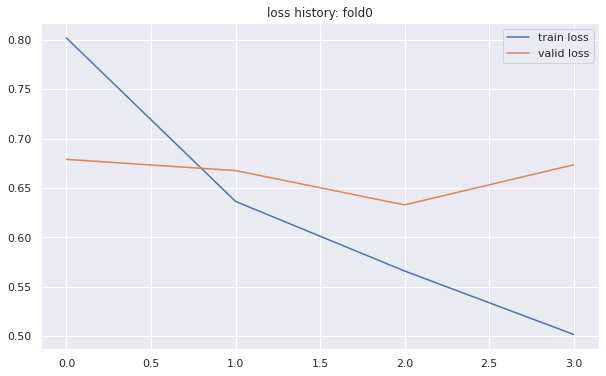

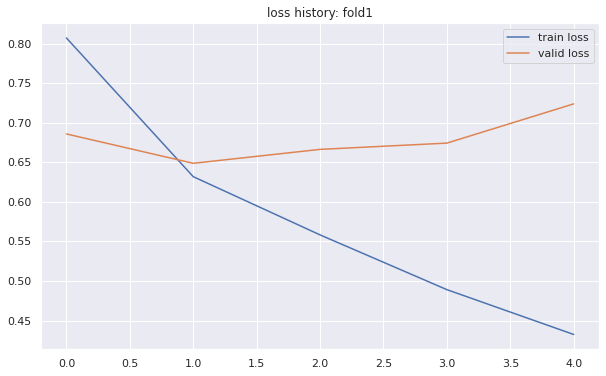

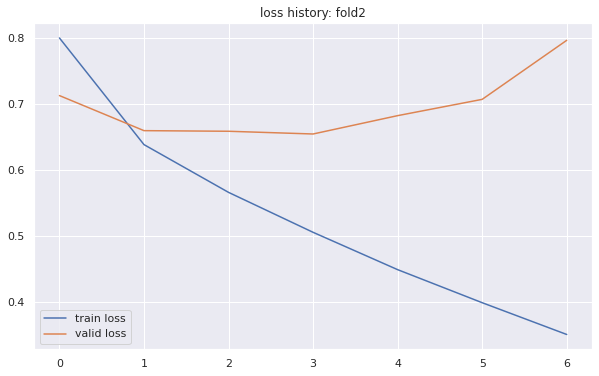

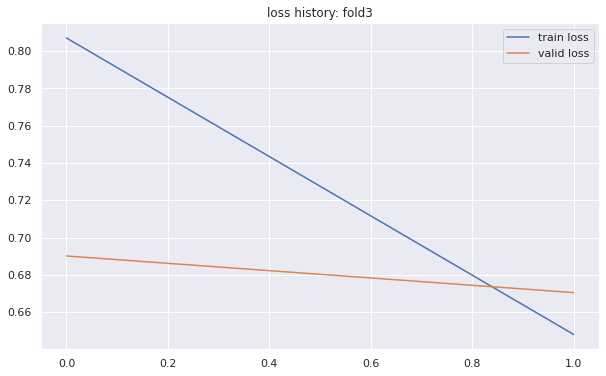

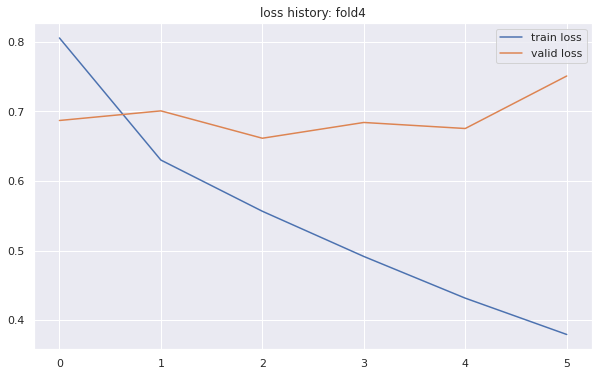

In [ ]:
start_time = time.time()

oof = pd.DataFrame()
for i_fold in range(Config.n_fold):
    print('='*50, f'Fold{i_fold} training', '='*50)
    tokenizer = LongformerTokenizerFast.from_pretrained(Config.model_name, add_prefix_space = True)
    model = FeedbackModel()
    model = model.to(device)
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=Config.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    df_train = alltrain_texts[alltrain_texts['fold'] != i_fold].reset_index(drop = True)
    ds_train = FeedbackPrizeDataset(df_train, tokenizer, Config.max_length, True)
    df_val = alltrain_texts[alltrain_texts['fold'] == i_fold].reset_index(drop = True)
    val_idlist = df_val['id'].unique().tolist()
    df_val_eval = df_alltrain.query('id==@val_idlist').reset_index(drop=True)
    ds_val = FeedbackPrizeDataset(df_val, tokenizer, Config.max_length, True)
    dl_train = DataLoader(ds_train, batch_size=Config.train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
    dl_val = DataLoader(ds_val, batch_size=Config.valid_batch_size, shuffle=False, num_workers=2, pin_memory=True)

    best_val_loss = np.inf
    criterion = nn.CrossEntropyLoss()

    train_loss_history = []
    valid_loss_history = []
    valid_f1_history = []

    # Early Stopping
    model_filename = f'{Config.model_dir}/{Config.model_savename}_{i_fold}.bin'
    earlystopping = EarlyStopping(patience=1, verbose=True, direction='max') 

    for epoch in range(1, Config.n_epoch + 1):
        print('-'*30, f'Epoch{epoch}', '-'*30)
        # Training
        train_loss = train_fn(model, dl_train, optimizer, epoch, criterion, scheduler) # train
        train_loss_history.append(train_loss) # train lossの保存

        # Validation
        valid_loss, _oof, val_f1avg = valid_fn(model, df_val, df_val_eval, dl_val, epoch, criterion) # validation
        valid_loss_history.append(valid_loss) # valid lossの保存
        valid_f1_history.append(val_f1avg) # valid f1の保存

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            _oof_fold_best = _oof
            _oof_fold_best['fold'] = i_fold
            # validation lossを更新したらモデルを保存する
            torch.save(model.state_dict(), model_filename)
            print(f'{model_filename} saved')

        # early stoppingに引っ掛かったらmodelを保存する
        earlystopping(val_f1avg, model) # callメソッド呼び出し
        if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
            print("Early Stopping!")
            break
    print(f'Fold{i_fold} best f1 score: {np.max(valid_f1_history)}')

    # lossの描画
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    sns.lineplot(data=train_loss_history, label='train loss')
    sns.lineplot(data=valid_loss_history, label='valid loss')
    ax.set_title(f'loss history: fold{i_fold}')
    plt.legend();

    oof = pd.concat([oof, _oof_fold_best])
    del df_train, ds_train, df_val, val_idlist, df_val_eval, ds_val, dl_train, dl_val, tokenizer, model, optimizer
    gc.collect()
    torch.cuda.empty_cache()

oof.to_csv(f'{Config.output_dir}/oof_{Config.name}.csv', index=False)
print('elapsed time:', f'{time.time() - start_time:.1f}s')

In [ ]:
oof.head()

In [ ]:
oof.to_csv(f'{Config.output_dir}/oof_{Config.name}.csv', index=False)

In [ ]:
pd.read_csv(f'{Config.output_dir}/oof_{Config.name}.csv').head()

FileNotFoundError: ignored

## cv score

In [ ]:
if Config.is_debug:
    idlist = alltrain_texts['id'].unique().tolist()
    df_train = df_alltrain.query('id==@idlist')
else:
    df_train = df_alltrain.copy()
print(f'overall cv score: {oof_score(df_train, oof)}')

In [ ]:
# Inference